In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Necessary Libraries

In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torchvision import datasets
import albumentations  as A
import numpy as np
import matplotlib.pyplot as plt

import requests
from pathlib import Path

from PIL import Image
import os

!pip install split-folders
import splitfolders

## Data Gathering

In [4]:
!rm -rf /kaggle/working/*

In [5]:
def create_class_directories(base_dir, class_names):

    for class_name in class_names:
        class_dir = Path(base_dir / class_name)
        class_dir.mkdir(parents=True, exist_ok=True)


data_path = Path("data/")
class_names = [ "dog_entities", "non_dog_entities"]


create_class_directories(data_path,class_names)

In [6]:
def save_images_to_dir(image_paths, destination_dir):
    destination_dir = Path(destination_dir)
    destination_dir.mkdir(parents=True, exist_ok=True)
    
    for img_path in image_paths:
        if "_DS_Store" in img_path:
            continue
        img = Image.open(img_path)
            
        if img.mode == "P":
            img = img.convert("RGBA")
            img = img.convert("RGB")
        dest_path = destination_dir / Path(img_path).name
        img.save(dest_path)

def collect_images(base_dir, limit=None, subdirs=None):
    img_path_list = []
    if subdirs:
        for subdir in subdirs:
            full_path = Path(base_dir) / subdir
            img_names = os.listdir(full_path)[:limit]
            img_path_list.extend([str(full_path / img_name) for img_name in img_names])
    else:
        img_names = os.listdir(base_dir)[:limit]
        img_path_list = [str(Path(base_dir) / img_name) for img_name in img_names]
    return img_path_list

### Dog-Entity Class : 903 images

In [7]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="qpVkzgWharR8jmlCO7nm")
project = rf.workspace("harshkalita").project("dog-4nl7c")
dataset = project.version(3).download("folder")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 34.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled


Extracting Dataset Version Zip to dog-3 in folder:: 100%|██████████| 917/917 [00:00<00:00, 8791.04it/s]


In [8]:
base_dir = '/kaggle/working/dog-3/train/dog'
classes = os.listdir(base_dir)
img_path_list_dog = collect_images(base_dir)
save_images_to_dir(img_path_list_dog, data_path/"dog_entities")
print(len(img_path_list_dog))

903


In [9]:
# import random
# random.shuffle(list_dogs_imgs)
# split_80_20 = int(len(list_dogs_imgs)*0.8)
# train_imgs_path = list_dogs_imgs[:split_80_20 ]
# test_imgs_path = list_dogs_imgs[split_80_20+1: ]
# len(train_imgs_path),len(test_imgs_path)

### Non Dog Entity Class : 810 images

In [10]:
# PennFudanPed for People
images_fudanped_names = os.listdir("/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages")
base_dir_fudanped = "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages"
list_miscellaneous_img_path_fudanped = [os.path.join(base_dir_fudanped, img) for img in images_fudanped_names]


# Buildings vs Forests Dataset
base_dir_buildings_forests = "/kaggle/input/buildings-vs-forests/buildings-vs-forests/traning_set"
building_forest_classes = os.listdir(base_dir_buildings_forests)
list_miscellaneous_img_path_buildings_forests = collect_images(base_dir_buildings_forests, subdirs=building_forest_classes, limit=320) # Assuming limit per class


list_miscellaneous_img_path = list_miscellaneous_img_path_fudanped + list_miscellaneous_img_path_buildings_forests
save_images_to_dir(list_miscellaneous_img_path, data_path/"non_dog_entities")
print(len(list_miscellaneous_img_path))
print("DONE WITH DATA GATHERING PART!!!")

810
DONE WITH DATA GATHERING PART!!!


## Splitting Data

In [11]:
splitfolders.ratio('data', output="dataset", seed=42, ratio=(.7, 0.2,0.1)) 

Copying files: 1713 files [00:00, 6178.54 files/s]


## Creating DataLoaders

In [12]:
def create_dataloaders(
train_dir,
test_dir,
train_transform,
test_transform,
batch_size,
num_workers = 0): # make it 0 for now
    if num_workers == None:
        num_workers = int(min(os.cpu_count(),4))
    
    train_data = datasets.ImageFolder(root=train_dir,transform=train_transform,target_transform=None)
    test_data = datasets.ImageFolder(root=test_dir,transform=test_transform)
    
    class_names = train_data.classes
    
    train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
    )
    test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
    )
    return train_dataloader,test_dataloader
    

In [13]:
train_dir = "/kaggle/working/dataset/train"
test_dir = "/kaggle/working/dataset/val"

transform = T.Compose([
    T.Resize(size = (224,224)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
    
])

# pretrained_effnet_transform = pretrained_weights.transforms()

train_dataloader,test_dataloader =  create_dataloaders(train_dir,test_dir,transform,transform,32)

In [14]:
print(f"per batch will have : {len(train_dataloader)} images in training data and {len(test_dataloader)} images in testing data")

per batch will have : 38 images in training data and 11 images in testing data


In [15]:
train_dataloader.dataset, test_dataloader.dataset

(Dataset ImageFolder
     Number of datapoints: 1199
     Root location: /kaggle/working/dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ),
 Dataset ImageFolder
     Number of datapoints: 342
     Root location: /kaggle/working/dataset/val
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ))

In [16]:
imgs,labels = next(iter(train_dataloader))
imgs.shape,labels

(torch.Size([32, 3, 224, 224]),
 tensor([0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
         0, 0, 1, 1, 0, 1, 1, 0]))

In [17]:
class_names = train_dataloader.dataset.classes 
class_names

['dog_entities', 'non_dog_entities']

## Visualizing our DataLoader

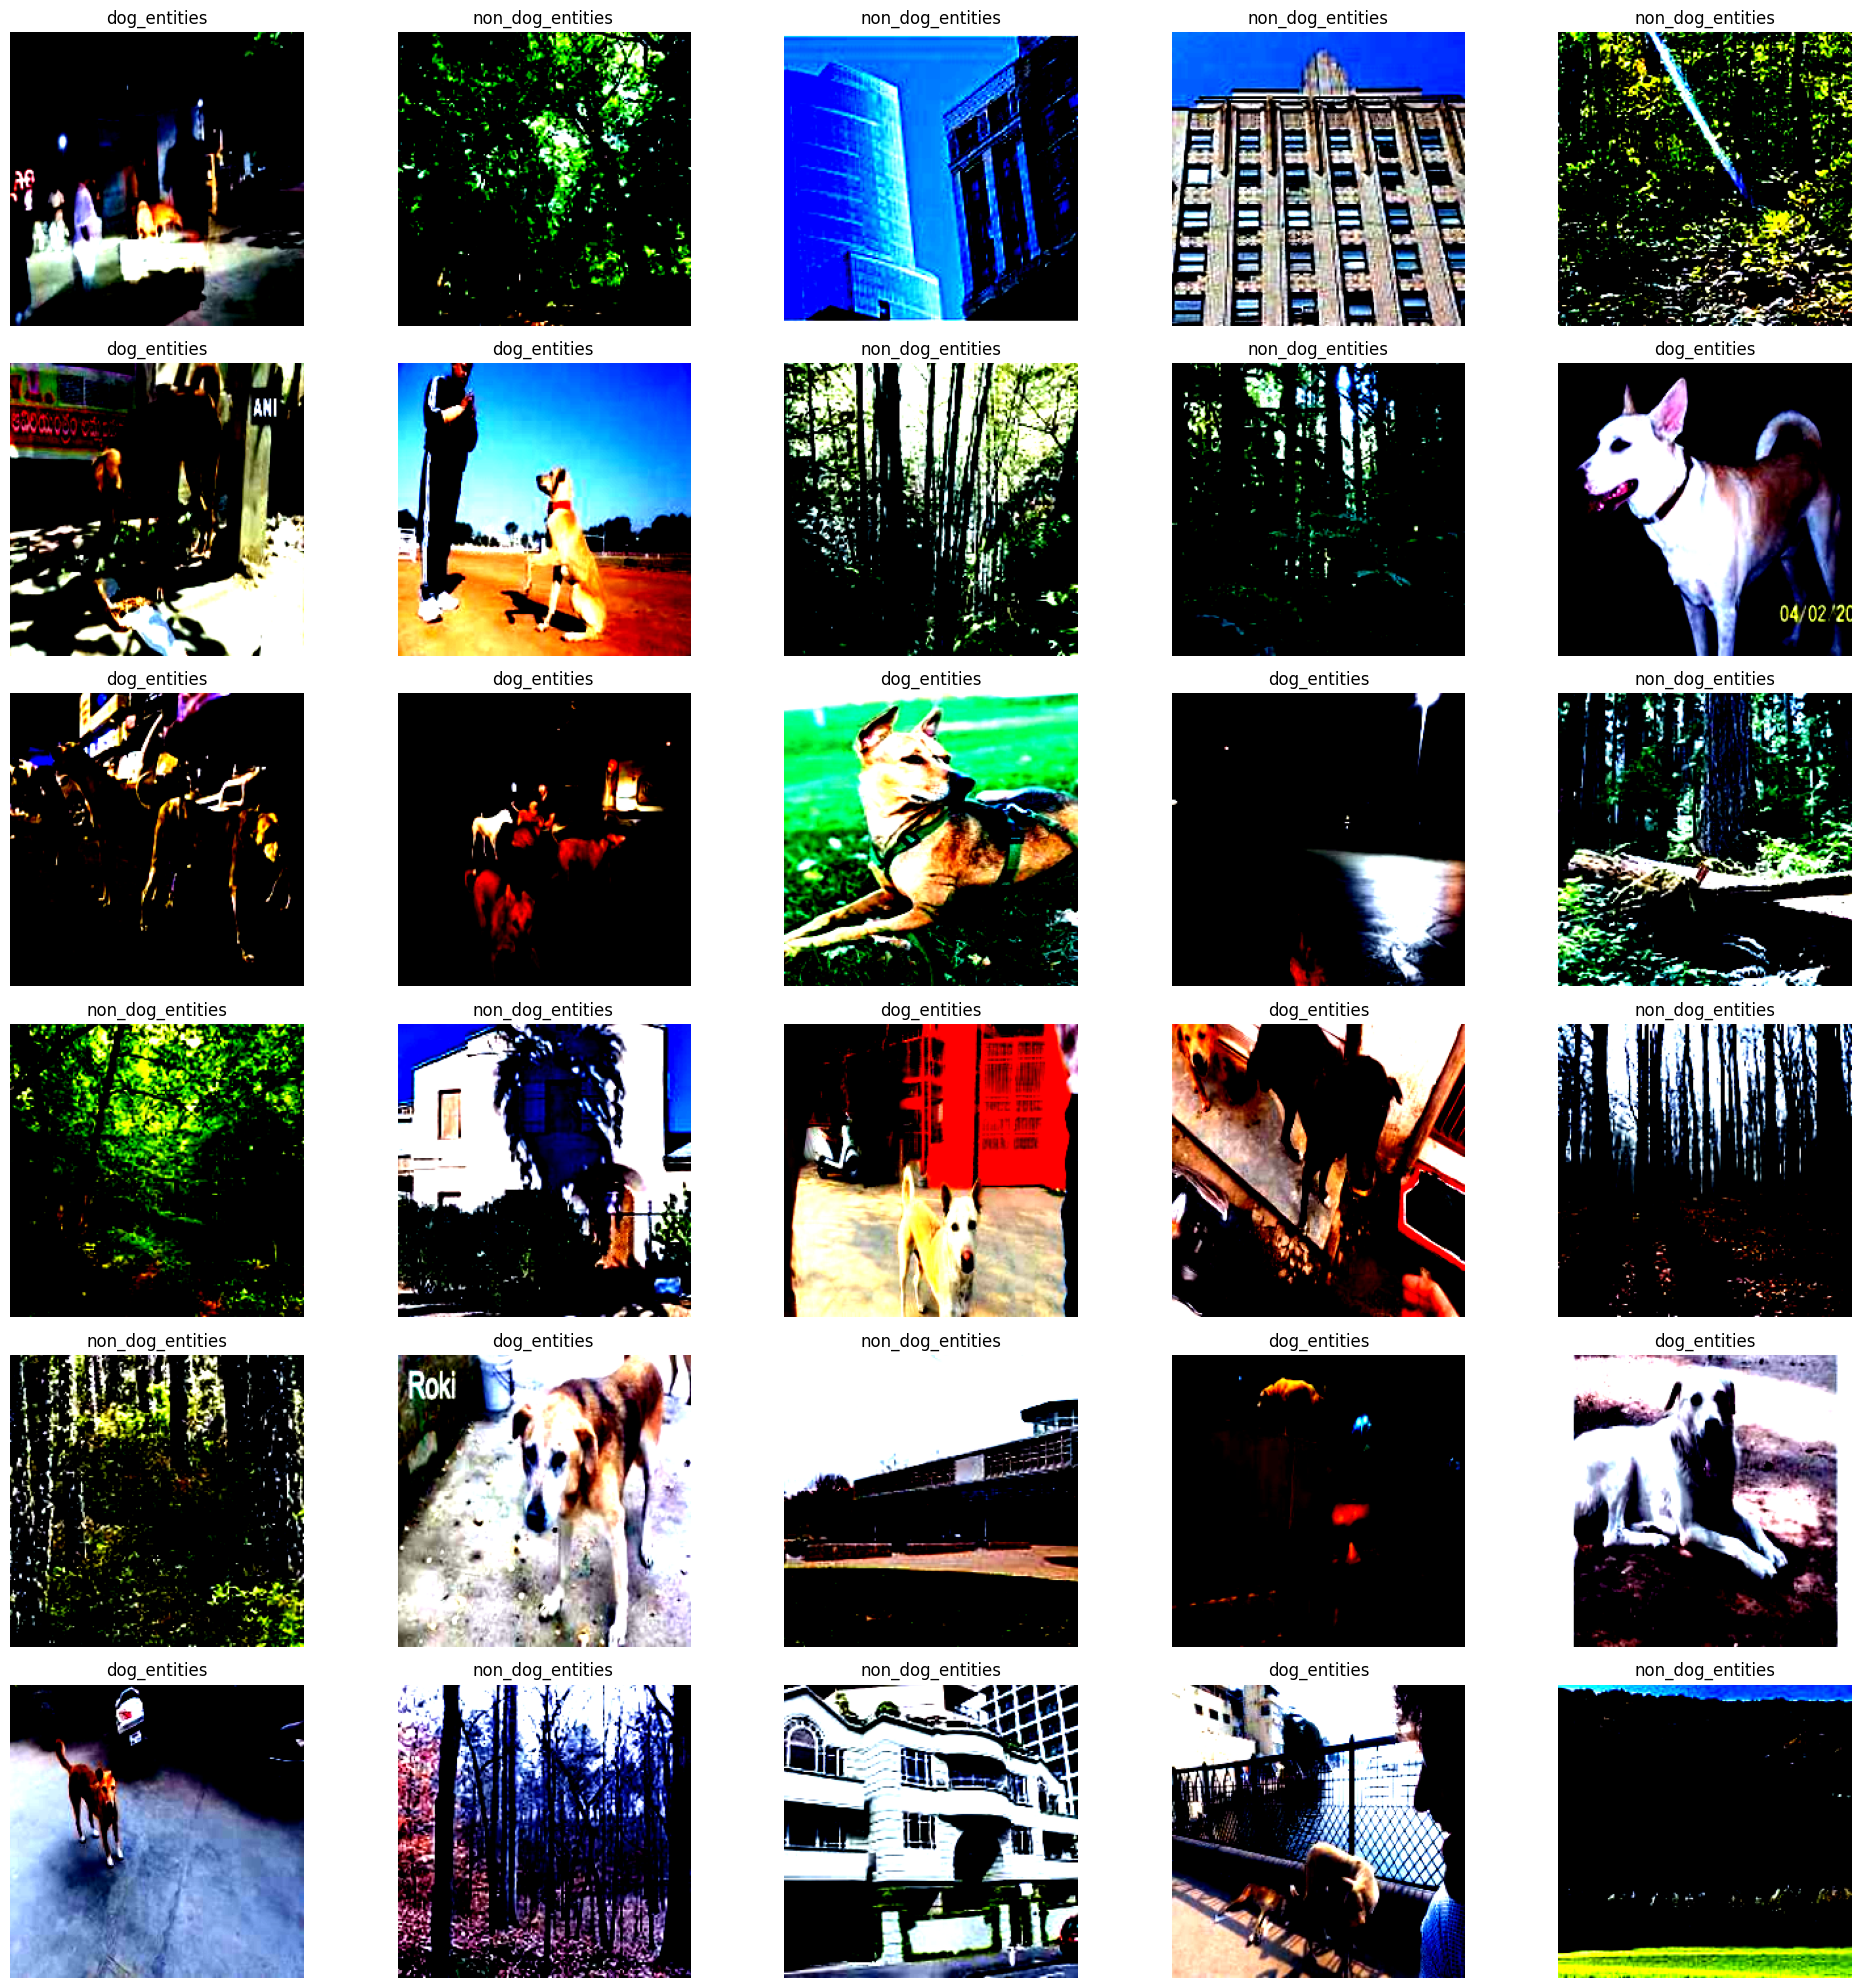

In [18]:
def tensor_to_image(tensor):
     return tensor.permute(1, 2, 0).numpy()

# Plotting
fig, axs = plt.subplots(nrows = 6, ncols=5, figsize=(20, 20))
class_names = train_dataloader.dataset.classes  

for i, ax in enumerate(axs.flat):
    img = tensor_to_image(imgs[i])  
    label = class_names[labels[i]]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


Looks great!! 

## Model Definition

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
pretrained_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
pretrained_effnet = torchvision.models.efficientnet_b0(weights=pretrained_weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 113MB/s] 


In [20]:
pretrained_weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [21]:
for param in pretrained_effnet.parameters():
    param.requires_grad = False

In [22]:
print("Original classifier:", pretrained_effnet.classifier)

Original classifier: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [23]:
in_features = pretrained_effnet.classifier[1].in_features
pretrained_effnet.classifier[1] = nn.Sequential(
    nn.Linear(in_features=in_features, out_features=1, bias=True),
    nn.Sigmoid()
    ).to(device)


In [24]:
for param in pretrained_effnet.classifier.parameters():
    param.requires_grad = True

In [25]:
print("Modified classifier:", pretrained_effnet.classifier)

Modified classifier: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Sequential(
    (0): Linear(in_features=1280, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


## Training Part 

In [26]:
from typing import Tuple
from typing import Dict, List

def train_step(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss, correct_predictions, total_predictions = 0.0, 0, 0
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X).squeeze()
        loss = criterion(output, y.float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*X.size(0)
        y_pred_class = output>=0.5
        
        correct_predictions += (y_pred_class == y).sum().item()
        total_predictions += y.size(0)
        
    avg_loss = train_loss / total_predictions
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def test_step(model, dataloader, criterion, device):
    model.eval()
    test_loss, correct_predictions, total_predictions = 0.0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X).squeeze()
            loss = criterion(output, y.float())
            
            test_loss += loss.item() * X.size(0)
            y_pred_class = output>=0.5
            
            correct_predictions += (y_pred_class == y).sum().item()
            total_predictions += y.size(0)
            
    avg_loss = test_loss / total_predictions
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy


In [27]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          criterion: torch.nn.Module,
          scheduler,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    
    results = {
        "train_loss" : [],
        "train_acc" : [],
        "test_loss" : [],
        "test_acc" : []
    }
    
    for epoch in range(epochs):
        train_loss,train_acc = train_step(model = model,
                                         dataloader = train_dataloader,
                                         criterion = criterion,
                                         optimizer = optimizer,
                                         device = device)
        test_loss,test_acc = test_step(model = model,
                                      dataloader = test_dataloader,
                                      criterion = criterion,
                                      device=device)
        scheduler.step()
        print(f"Epoch: {epoch+1} | "
             f"train_loss: {train_loss:.3f} | "
             f"train_acc: {train_acc:.3f} | "
             f"test_loss: {test_loss:.3f} | "
             f"test_acc: {test_acc:.3f} | "
             )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [28]:
imgs[0].shape

torch.Size([3, 224, 224])

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=pretrained_effnet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


model_results = train(model=pretrained_effnet,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        criterion=criterion,
                      scheduler = scheduler,
                        epochs=NUM_EPOCHS,
                     device=device)

Epoch: 1 | train_loss: 0.241 | train_acc: 0.959 | test_loss: 0.179 | test_acc: 0.977 | 
Epoch: 2 | train_loss: 0.139 | train_acc: 0.983 | test_loss: 0.123 | test_acc: 0.982 | 
Epoch: 3 | train_loss: 0.113 | train_acc: 0.975 | test_loss: 0.101 | test_acc: 0.980 | 
Epoch: 4 | train_loss: 0.093 | train_acc: 0.986 | test_loss: 0.089 | test_acc: 0.982 | 
Epoch: 5 | train_loss: 0.074 | train_acc: 0.992 | test_loss: 0.083 | test_acc: 0.985 | 


Results look promising, let's visualize them

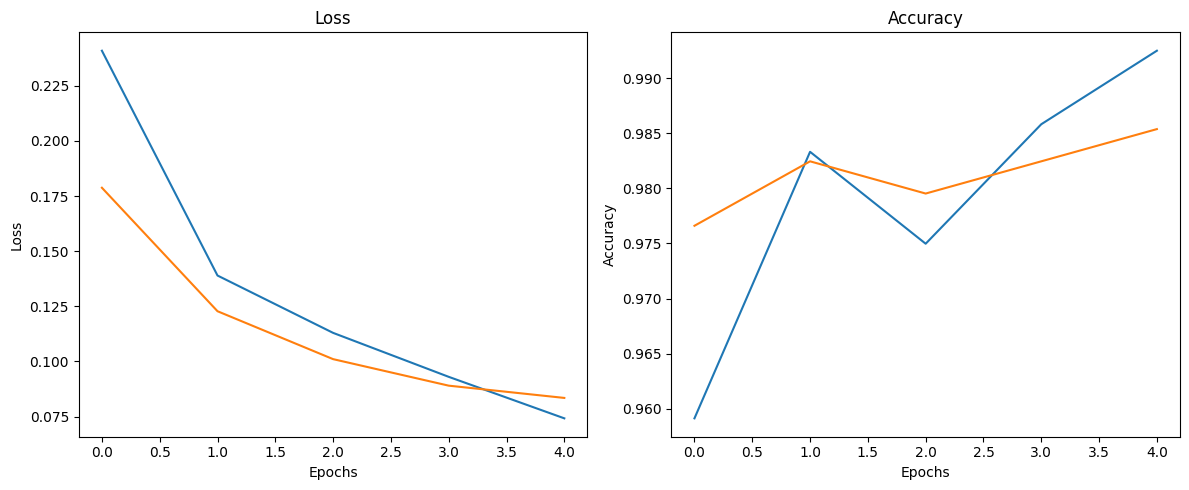

In [31]:
epochs = range(len(model_results['train_loss']))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training Loss
axs[0].plot(epochs, model_results['train_loss'], label='Train Loss')
axs[0].plot(epochs, model_results['test_loss'], label='Test Loss')
axs[0].set_title("Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

# Plot Training Accuracy
axs[1].plot(epochs, model_results['train_acc'], label='Train Accuracy')
axs[1].plot(epochs, model_results['test_acc'], label='Test Accuracy')
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

## Testing with unknown data

In [32]:
!rm -rf /kaggle/working/test/*

t = Path('test/')
class_names = [ "dog_entities", "non_dog_entities"]
create_class_directories(t,class_names)

base_dir = '/kaggle/input/cat-and-dog/test_set/test_set/dogs'
img_path_list_dog = collect_images(base_dir)
save_images_to_dir(img_path_list_dog, t/"dog_entities")
print(len(img_path_list_dog))

base_dir = "/kaggle/input/road-vehicle-images-dataset/trafic_data/valid/images"
img_path_list_non = collect_images(base_dir)
save_images_to_dir(img_path_list_non, t/"non_dog_entities")
print(len(img_path_list_non))

1013
300


## Visualizing the Results with new data: score above 0.5 should be dog entity class  🤞

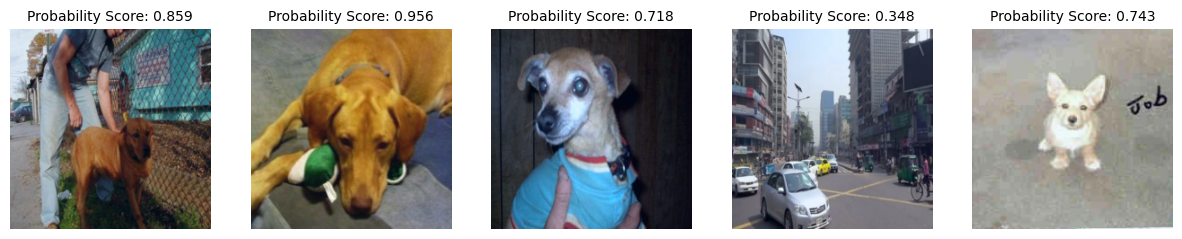

In [33]:
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()  
    images_so_far = 0
    plt.figure(figsize=(15, 15)) 

    with torch.no_grad(): 
        for i, (inputs, _) in enumerate(dataloader): 
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()  

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 5, 5, images_so_far)  
                ax.axis('off')
                ax.set_title(f'Probability Score: {1 - outputs[j].item():.3f}', fontsize=10)
                
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = (img - img.min()) / (img.max() - img.min())
                plt.imshow(img)

                if images_so_far == num_images:
                    plt.show()
                    return

dataset = ImageFolder(root='/kaggle/working/test', transform=transform)
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
visualize_predictions(pretrained_effnet,dataloader,device)


## It looks like our model is predicting accurate results, let's load the model !!

In [34]:
MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok = True)

MODEL_NAME = "dog_detection_effnetB0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj=pretrained_effnet.state_dict(), f = MODEL_SAVE_PATH)

In [36]:
model = torchvision.models.efficientnet_b0(pretrained=False) 
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Linear(in_features=in_features, out_features=1, bias=True),
    nn.Sigmoid()
    ).to(device)
print(model.classifier)
state_dict = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(state_dict)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Sequential(
    (0): Linear(in_features=1280, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


<All keys matched successfully>

## Well, we completed the 1st stage of our application, this will come in use for validating the images before sending the image to my 2nd stage model which is going to be an object detection model for my Bark Rescue Application :)